# Test Energy Ordering
Determine whether our machine learning models order polymorphs based on relative stability correctly.

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm_notebook as tqdm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold
from sklearn import metrics
from scipy.stats import kendalltau
from glob import glob
import numpy as np
import pandas as pd
import json
import os

## Load in the Data
Read in the data from JSON to create a DataFrame

In [2]:
def load_data(path):
    """Read in a JSON file from disk, and return a DataFrame"""
    
    temp = json.load(open(path))
    data = pd.DataFrame(temp['entries']).drop(['properties', 'poscar', 'name'], axis='columns')
    data['class'] = data['class'].apply(lambda x: x['measured'])
    data = data[~data['class'].isnull()]
    return data

In [3]:
%%time
data = dict([(os.path.basename(name)[:-5], load_data(name)) for name in glob(os.path.join('..', 'datasets', '*.json'))])

CPU times: user 43.8 s, sys: 2.07 s, total: 45.9 s
Wall time: 45.8 s


## Run the Test
Our test is going to work by witholding all 3 polymorphs at a certain composition in the test set, training a model on the remaining data, and then assessing how well it ranked the polymorphs. As we have ~30k unique composition, we are going to hold out 10% of the compositions at one time

In [4]:
model = Pipeline([
    ('imputer', Imputer()),
    ('rf', RandomForestRegressor(n_estimators=100, n_jobs=-1)),
])

In [ ]:
data['quat-heuslers']['predicted_class'] = np.ones_like(data['quat-heuslers']['class'])

In [ ]:
for train_ind, test_ind in tqdm(GroupKFold(n_splits=10).split(data['quat-heuslers']['attributes'].tolist(),
                                                              data['quat-heuslers']['class'],
                                                              data['quat-heuslers']['composition'])):
    # Get the QH dataset
    qh_train = data['quat-heuslers'].loc[train_ind]
    qh_test = data['quat-heuslers'].loc[test_ind]
    
    # Append rest of OQMD to QH training set
    train_data = pd.concat([qh_train, data['oqmd-no-heusler'], data['heuslers']])
    train_X = np.array(train_data['attributes'].tolist(), dtype=np.float32)
    test_X = np.array(qh_test['attributes'].tolist(), dtype=np.float32)
    
    # Train and test the model
    model.fit(train_X, train_data['class'])
    data['quat-heuslers'].loc[qh_test.index, 'predicted_class'] = model.predict(test_X)

## Analyze the Results
Determine how well the ranking performance worked. We will do this two different ways:

1. Measure the [Kendall rank correllation coefficient](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient) for each composition where we calculated all three prorotypes. If the algorithm assigns orderings randomly, this score should be zero. 

2. Measure how often the algorithm is correct. There are 6 possible orderings of three prototypes and only one is correct. If the model assigns ordering randomly, we should get the correct one 1/6<sup>th</sup> of the time.

In [12]:
scores = []
for gid, group in data['quat-heuslers'].groupby('composition'):
    if len(group) != 3:
        continue
    ## Apply a slight variation so the al
    tau = kendalltau(group['class'], group['predicted_class']).correlation
    min_stability = group['class'].min()
    mean_stability = group['class'].mean()
    range_stability = group['class'].max() - group['class'].min()
    
    scores.append({'composition': gid, 'tau': tau, 'min_stability': min_stability,
                  'mean_stability': mean_stability, 'range_stability': range_stability})
scores = pd.DataFrame(scores)
print('Evaluated %d compositions'%len(scores))

Evaluated 5813 compositions


In [13]:
print('Mean Kendall Tau:', scores['tau'].mean())

Mean Kendall Tau: 0.656733880142


In [14]:
print('Fraction perfect:', float(sum([k>0.99 for k in scores['tau']])) / len(scores))

Fraction perfect: 0.5656287631171513


*Finding*: The ranking performance is strong. We find an average Kendall tau of 0.65 and the model predicted the correct order in 56% of cases.

### Understanding the performance
Answering a few questions about the performance of the model on this ranking task

#### Is it more difficult to distinguish between polymorphs that are closer in energy?

,quintile,tau
0,0,0.370301
1,1,0.633343
2,2,0.712406
3,3,0.766778
4,4,0.801318


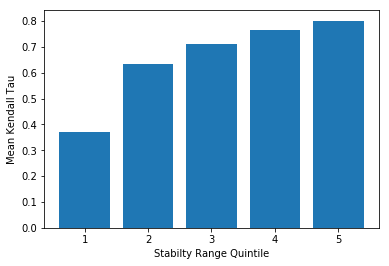

In [15]:
fig, ax = plt.subplots()

n_bins = 5
ranges = np.percentile(scores['range_stability'], np.linspace(0, 100, n_bins+1))
averages = [scores.query('range_stability >= %f and range_stability <= %f'%(ranges[i], ranges[i+1]))['tau'].mean()
            for i in range(n_bins)]

ax.bar(range(n_bins), averages)

ax.set_xticks(range(n_bins))
ax.set_xticklabels('%d'%(i+1) for i in range(n_bins))

ax.set_ylabel('Mean Kendall Tau')
ax.set_xlabel('Stabilty Range Quintile')

pd.DataFrame({'quintile':range(n_bins), 'tau':averages})

*Finding*: The ranking performance is worse for compositions with smaller differences between the energies of each polymorph.

#### How is the ranking pefromance on the more-stable QHs?

,quintile,tau
0,0,0.731738
1,1,0.671267
2,2,0.637771
3,3,0.590516
4,4,0.652034


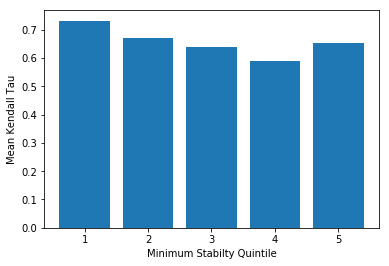

In [16]:
fig, ax = plt.subplots()

n_bins = 5
ranges = np.percentile(scores['min_stability'], np.linspace(0, 100, n_bins+1))
averages = [scores.query('min_stability >= %f and min_stability <= %f'%(ranges[i], ranges[i+1]))['tau'].mean()
            for i in range(n_bins)]

ax.bar(range(n_bins), averages)

ax.set_xticks(range(n_bins))
ax.set_xticklabels('%d'%(i+1) for i in range(n_bins))

ax.set_ylabel('Mean Kendall Tau')
ax.set_xlabel('Minimum Stabilty Quintile')

pd.DataFrame({'quintile':range(n_bins), 'tau':averages})

*Finding*: The ranking performance is not very different for compositions that have more stable polymorphs and those with less table polymorphs. In fact, the ranking performance is strongest for the 1st quintile (i.e., the 20% of compounds with the polymorph that are the most stable).

## Measure Performance on Whole Dataset
Get summary statistics of the performance of the model across the entire test set. We might as well use this opporunity to measure cross-validation scores.

In [19]:
for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
    score = getattr(metrics,scorer)(data['quat-heuslers']['class'], data['quat-heuslers']['predicted_class'])
    print(scorer, score)

r2_score 0.936355600241
mean_absolute_error 0.0568246295543
mean_squared_error 0.00629738546228


Make a CV parity plot

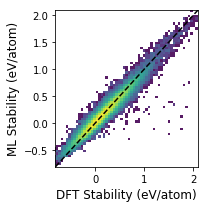

In [20]:
fig, ax = plt.subplots()

ax.hist2d(data['quat-heuslers']['class'], data['quat-heuslers']['predicted_class'],
          norm=LogNorm(), bins=64, cmap='viridis', alpha=0.9)

ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('DFT Stability (eV/atom)', fontsize=12)
ax.set_ylabel('ML Stability (eV/atom)', fontsize=12)

fig.set_size_inches(3, 3)
fig.tight_layout()
fig.savefig('parity_plot.png', dpi=320)
fig.savefig('parity_plot.pdf', dpi=320)